In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation of Hard-wall contacts with constrained conjugate gradient

Method is described in I.A. Polonsky, L.M. Keer, Wear 231, 206 (1999)

## Simulation of a periodic wavy surface

In [25]:
from PyCo.ContactMechanics import HardWall
from PyCo.SolidMechanics import PeriodicFFTElasticHalfSpace, FreeFFTElasticHalfSpace
from PyCo.Topography import Topography
from PyCo.System import make_system


### Define your simulation parameters

 #### Resolution
 You can choose an arbitrary nb_grid_pts (e.g. this of your measurement), but the fourier transformation algorithm FFT is particulary effective on powers of two.

In [26]:
nx, ny = 64, 64

size

In [27]:
sx,sy= 2* np.pi, 2*np.pi 

generate a bisinusoidal topography

In [28]:
x = np.arange(nx).reshape(-1,  1) * sx / nx
y = np.arange(ny).reshape( 1, -1) * sy / ny
h = 0.1  * np.sin(x) * np.sin(2*y) 

topography = Topography(h, size=(sx, sy), periodic=True)

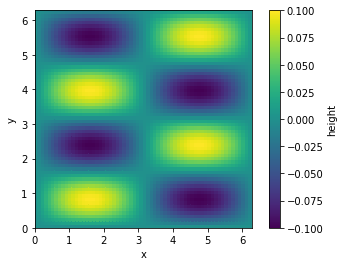

In [29]:
fig, ax = plt.subplots()

X, Y = np.meshgrid(np.arange(nx+1) * sx/nx, np.arange(ny+1) * sy/ny, indexing='ij') 
pcm = ax.pcolormesh(X,Y, topography.heights())
cb = plt.colorbar(pcm,ax= ax, label= "height")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect(1)

## Substrate: Computation of the Deformation

#### Contact Modulus 

This is the equivalent youngs Modulus $E^*$ as defined in Johnson, Contact Mechanics: 

$\frac{1}{E^*} = \frac{1-\nu_1^2}{E_1} + \frac{1-\nu_2^2}{E_2}$

If one of the two bodies is rigid, one of the terms drops.

For example for the contact of two steel bodies

In [30]:
Es =  1 /  (2 * (1-0.3**2) / 230000) # MPa

#### PeriodicFFTElasticHalfSpace

The substrates can compute the deformations as a function of the loads on the grid points (and vice-versa). 

`PeriodicFFTElasticHalfSpace` works in the Fourier domain because the relation between stress and strain is particularly simple there. For the linear elastic deformation of the halfspace: 

\begin{equation}
	\tilde{p}(\vec{q}) = \frac{E^*}{2} |\vec{q}| \tilde{u}(\vec{q})
\end{equation}

Where $\tilde{p}(\vec{q})$ and $\tilde{u}(\vec{q})$ are the fourier transformed of $p(\vec{x})$ and $u(\vec{x})$, resectively

The proportionality factors depend on the wavevector and are precomputed at the ininitialization of the simulation according to the topography size and nb_grid_pts.

In [31]:
substrate = PeriodicFFTElasticHalfSpace(nb_grid_pts=(nx,ny), young=Es, size = (sx, sy))

## Interaction 

`interaction` gives the relation between gap $g$ and pressure $p$. 

Here the solution has to satisfy the contact condition: the bodies cannot interpenetrate and the non-contacting surfaecs are pressure free. 

  \begin{array}{c}
  p= 0, g > 0 \\
  p \in [0,\infty], g=0  \\
  g >= 0  
  \end{array}
with $p$ the pressure and $g$ the gap.

This is equivalent to a hard wall repulsion. We formally tell the system we do a hard-wall simulation by passing the interaction `Hardwall`. However the contact constraint is directly implemented in the algorithm and `Hardwall` is never evaluated. 

In [32]:
interaction = HardWall()

## System

topography, interaction and substrate together define completely a contact mechanics system. Depending on which type of interaction and substrate was specified, `make_system` will return the most suited computation algorithm. 

In [33]:
system = make_system(substrate, interaction, topography)

## Solve the contact mechanics problem

### given offset

In [34]:
offset = 0.
sol = system.minimize_proxy(offset=offset)
assert sol.success 

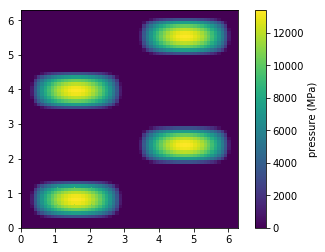

In [35]:
fig,ax=plt.subplots()
pcm = ax.pcolormesh(X,Y, system.force / system.area_per_pt)
cb = plt.colorbar(pcm,ax= ax, label= "pressure (MPa)")
ax.set_aspect(1)

If you solve it for a succession of gaps it's more efficient to use the solution for the last step as an initial guess.

AssertionError:      fun: 1055.6669873053183
     jac: array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])
   maxcv: {'max_pen': 0.001594484721669509, 'max_pres': 0.0}
 message: 'Reached maxiter = 100000'
    nfev: 200001
     nit: 100000
  offset: -0.029999999999999995
 success: False
       x: array([[0.0071614 , 0.00718619, 0.00725344, ..., 0.00734164, 0.00724458,
        0.00718175],
       [0.00724506, 0.00742719, 0.0076538 , ..., 0.00698605, 0.00702778,
        0.00711226],
       [0.00748944, 0.00784053, 0.00824796, ..., 0.00680212, 0.00697264,
        0.0072002 ],
       ...,
       [0.00787436, 0.00742397, 0.00705547, ..., 0.00970516, 0.00902326,
        0.00840874],
       [0.00747882, 0.00719405, 0.0069706 , ..., 0.00867152, 0.00822729,
        0.00782509],
       [0.00723971, 0.0071113 , 0.00703105, ..., 0.00789404, 0.00763911,
        0.00741727]])

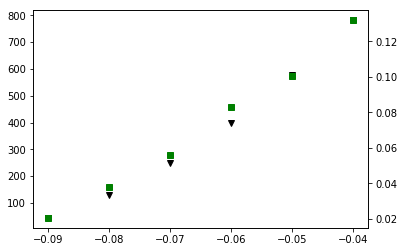

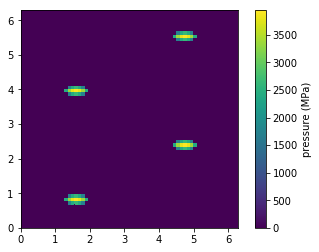

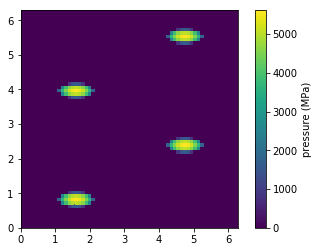

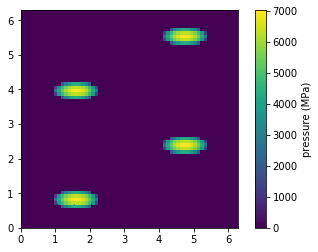

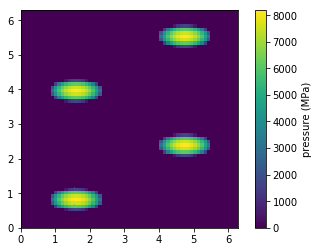

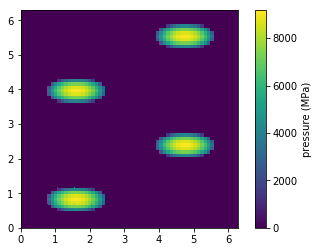

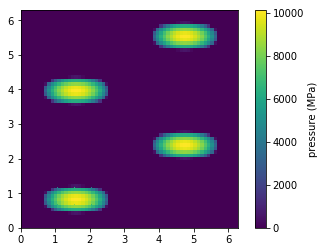

In [37]:
fig, ax = plt.subplots()
axa = ax.twinx()

disps0 = None # you don't have a 
for offset in np.linspace(-0.9,0,10) * 0.1 :
    sol = system.minimize_proxy(offset=offset, disp0 = disps0, pentol= 1e-9, maxiter = 100000)
    assert sol.success, "{}".format(sol)
    disps0 = system.disp
    
    lf, = ax.plot(offset, system.compute_normal_force() / (sx * sy), "vk")
    la, = axa.plot(offset, system.compute_contact_area() / (sx * sy), "sg")
    
    figc,axc=plt.subplots()
    pcm = axc.pcolormesh(X,Y, system.force / system.area_per_pt)
    cb = plt.colorbar(pcm,ax= axc, label= "pressure (MPa)")
    axc.set_aspect(1)
    
lf.set_label("mean pressure")
la.set_label("relative area")
axa.legend()
ax.legend()
ax.set_ylabel("(MPa)")
axa.set_ylabel("A_{real} / A_{nominal}")

In [29]:
sol


     fun: 2258.7050406832495
     jac: array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])
   maxcv: {'max_pen': 0.0, 'max_pres': 0.0}
 message: 'Reached maxiter = 10000'
    nfev: 20001
     nit: 10000
  offset: -0.012222222222222225
 success: False
       x: array([[0.01257323, 0.01258612, 0.01262448, ..., 0.01268721, 0.01262451,
        0.01258614],
       [0.01260599, 0.01269215, 0.01280435, ..., 0.01250382, 0.01251254,
        0.01254624],
       [0.01270486, 0.0128657 , 0.01305443, ..., 0.01238922, 0.01246737,
        0.01257222],
       ...,
       [0.01287164, 0.01266504, 0.01248906, ..., 0.01367733, 0.01337832,
        0.01310945],
       [0.0127065 , 0.01257382, 0.0124689 , ..., 0.01327156, 0.01305608,
        0.01286736],
       [0.0126068 , 0.01254703, 

It is also possible to impose the force instead of penetration

Text(0, 0.5, 'A_{real} / A_{nominal}')

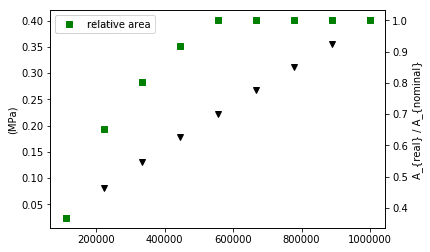

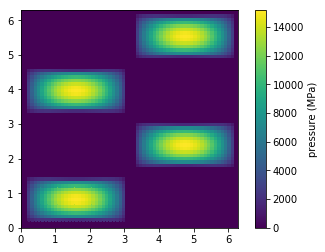

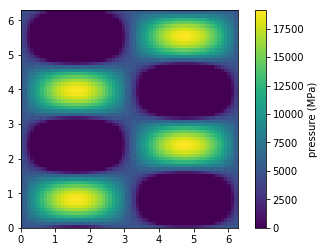

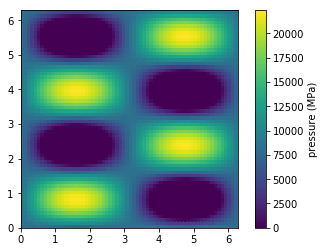

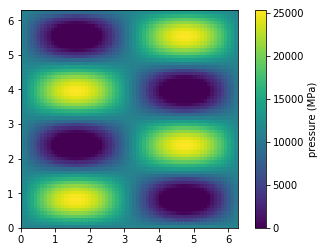

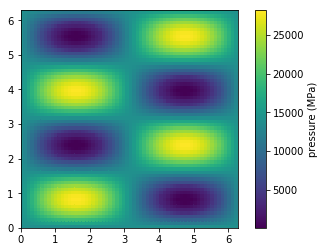

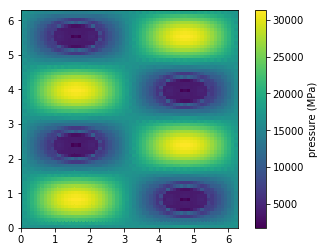

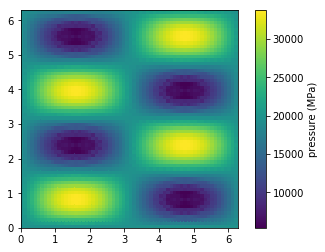

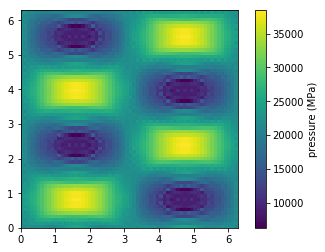

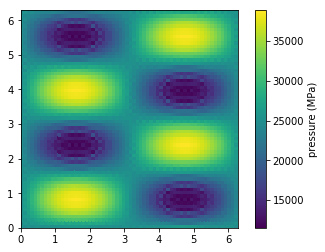

In [23]:
fig, ax = plt.subplots()
axa = ax.twinx()

disps0 = None # you don't have a 
for external_force in np.linspace(0,1000000,10)[1:]  :
    sol = system.minimize_proxy(external_force=external_force, disp0 = disps0, prestol= 1e-4, maxiter = 100000)
    assert sol.success, "{}".format(sol)
    disps0 = system.disp
    
    lf, = ax.plot(external_force, sol.offset, "vk")
    la, = axa.plot(external_force, system.compute_contact_area() / (sx * sy), "sg")
    
    figc,axc=plt.subplots()
    pcm = axc.pcolormesh(X,Y, system.force / system.area_per_pt)
    cb = plt.colorbar(pcm,ax= axc, label= "pressure (MPa)")
    axc.set_aspect(1)
    
lf.set_label("offset")
la.set_label("relative area")
axa.legend()
ax.legend()
ax.set_ylabel("(MPa)")
axa.set_ylabel("A_{real} / A_{nominal}")

# Nonperiodic Contact: Hertzian contact

In [ ]:
from PyCo.Topography import make_sphere
topography = make_sphere(radius=100, nb_grid_pts=(nx,ny), size=(sx, sy))

In [ ]:
fig, ax = plt.subplots()
X, Y = np.meshgrid(np.arange(nx+1) * sx/nx, np.arange(ny+1) * sy/ny, indexing='ij') 
pcm = ax.pcolormesh(X,Y, topography.heights())
cb = plt.colorbar(pcm,ax= ax, label= "height")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect(1)

## Substrate

The only difference here is that you have to use `FreeFFTElasticHalfspace` as a substrate. It uses almost the same method for the computation of the deformations, that actually uses periodic loading.

In [ ]:
substrate=FreeFFTElasticHalfSpace(topography.nb_grid_pts, Es, size=topography.size)

Internally, `FreeFFTElasticHalfspace` computes the deformations on a domain two times larger (in the senth of height and width) then the domain of interest where pressures are applied (active region). The padding regions are added so that the periodic replicas of the applied pressure do not have an influence on the active domain. 

This will not necessarily affect the way you perform the simulation and exploit it but keep this in mind when allocating computation resources.

In [ ]:
substrate.nb_grid_pts

In [ ]:
substrate.computational_resolution # in mpi (future) version this is called domain_resolution

In [ ]:
system=make_system(substrate, interaction, topography)

In [ ]:
for offset in [0.001, 0.01]:
    sol = system.minimize_proxy(offset=offset)
    assert sol.success 
    fig,ax=plt.subplots()
    pcm = ax.pcolormesh(X,Y, system.force / system.area_per_pt)
    cb = plt.colorbar(pcm,ax= ax, label= "pressure (MPa)")
    ax.set_aspect(1)

Make shure the computational Domain is big enough for your load ! 

If the pressures at the outer ring of the computational domain are not zero, the boundaries of the domain are probably inhibitting the motion of the contact line. That's why the `FreeBoundaryError` is raised.  

In [ ]:
offset = 0.2
sol = system.minimize_proxy(offset=offset)

In [ ]:
fig,ax=plt.subplots()
pcm = ax.pcolormesh(X,Y, system.force / system.area_per_pt)
cb = plt.colorbar(pcm,ax= ax, label= "pressure (MPa)")
ax.set_aspect(1)

# TODO: 

- Facory that puts together the system (automate a part of this code)
- prestol and pentol
